In [1]:
#Importing libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



## Load data

In [2]:
df= pd.read_csv('hotel_bookings.csv')
df.shape

(119390, 32)

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.tail()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
119385,City Hotel,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,2017-09-06
119386,City Hotel,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,2017-09-07
119387,City Hotel,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,2017-09-07
119388,City Hotel,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,2017-09-07
119389,City Hotel,0,205,2017,August,35,29,2,7,2,0.0,0,HB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,151.20,0,2,Check-Out,2017-09-07


In [5]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

## EDA

In [6]:
df.isnull().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company         

In [0]:
nan_fill = {"children:": 0.0, "agent": 0, "company": 0}
df = df.fillna(nan_fill)

Missing values in agent and company columns represent bookings that were not made by any travel agent or company. This should be considered as a group so I fill them fill them with 0.

In [0]:
df = df.dropna()

Columns country only has a small amount of missing values so we can drop these ones.

In [9]:
df.isnull().sum()

hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
agent                             0
company                           0
days_in_waiting_list              0
customer_type                     0
adr                         

In [10]:
df.shape

(118898, 32)

In [11]:
df.describe()

,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000,118898.000000
mean,0.371352,104.311435,2016.157656,27.166555,15.800880,0.928897,2.502145,1.858391,0.104207,0.007948,0.032011,0.087142,0.131634,0.221181,74.896264,10.562709,2.330754,102.003243,0.061885,0.571683
std,0.483168,106.903309,0.707459,13.589971,8.780324,0.996216,1.900168,0.578576,0.399172,0.097380,0.176029,0.845869,1.484672,0.652785,107.145761,53.513170,17.630452,50.485862,0.244172,0.792678
min,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,0.000000,18.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,70.000000,0.000000,0.000000
50%,0.000000,69.000000,2016.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,95.000000,0.000000,0.000000
75%,1.000000,161.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,1.000000,737.000000,2017.000000,53.000000,31.000000,16.000000,41.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,5400.000000,8.000000,5.000000


In [12]:
categorical_cols = df.select_dtypes('object').columns.tolist()
categorical_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'customer_type',
 'reservation_status',
 'reservation_status_date']

In [13]:
df.is_canceled.value_counts()

0    74745
1    44153
Name: is_canceled, dtype: int64

In [14]:
df.reservation_status.value_counts()

Check-Out    74745
Canceled     42950
No-Show       1203
Name: reservation_status, dtype: int64

reservation_status provides same information with is_canceled and since reservation_status_date also has relation with reservation_status, we should drop these two features

In [0]:
df.drop('reservation_status',axis=1, inplace=True)
df.drop('reservation_status_date',axis=1, inplace=True)

In [16]:
df.meal.value_counts()

BB           91863
HB           14434
SC           10638
Undefined     1165
FB             798
Name: meal, dtype: int64

In [0]:
#meal contains value Undefined which is equal to SC
df['meal'].replace("Undefined", "SC", inplace=True)

In [0]:
#adr < 0 doesnt make sense
df = df[df.adr > 0]

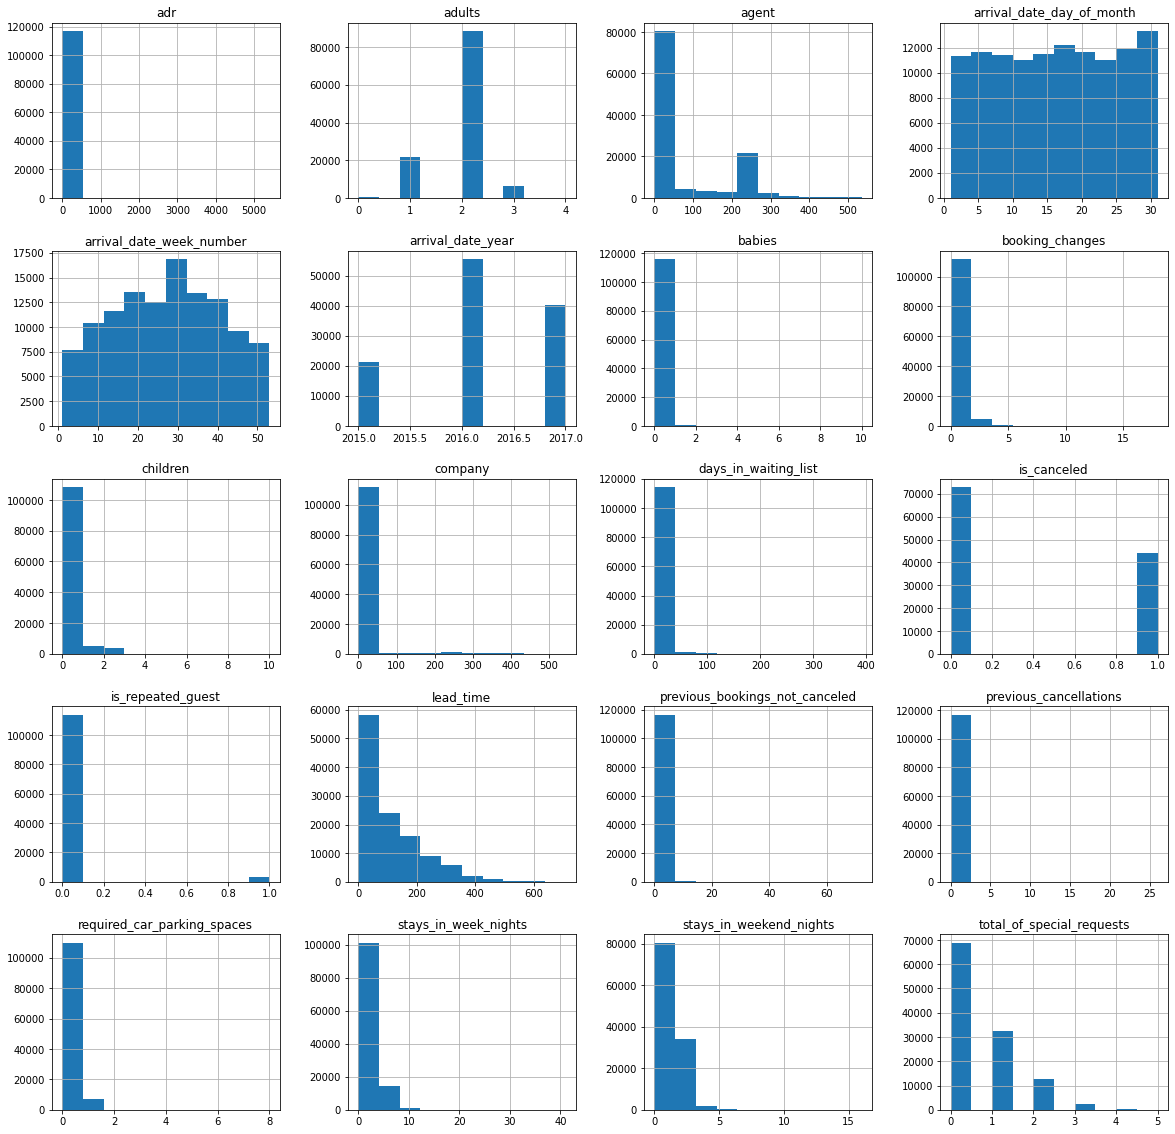

In [19]:
df.hist(figsize=(20,20))
plt.show()

Looks like some rows contain no guest (no adult, children, babies). This does not make sense, we should remove these from the dataset

In [20]:
zero_guests = list(df.loc[df["adults"]
                   + df["children"]
                   + df["babies"]==0].index)
df.drop(df.index[zero_guests], inplace=True)
df.shape

(116928, 30)

In [21]:
Xcorr = df.corr()["is_canceled"].sort_values()
Xcorr.abs().sort_values(ascending=False)[1:]

lead_time                         0.289270
total_of_special_requests         0.238333
required_car_parking_spaces       0.196835
booking_changes                   0.145125
previous_cancellations            0.110444
company                           0.082072
is_repeated_guest                 0.074938
adults                            0.054639
days_in_waiting_list              0.053925
previous_bookings_not_canceled    0.052890
agent                             0.048365
babies                            0.032505
adr                               0.028902
stays_in_week_nights              0.017752
arrival_date_year                 0.013957
arrival_date_week_number          0.008872
stays_in_weekend_nights           0.008028
arrival_date_day_of_month         0.006486
children                          0.004101
Name: is_canceled, dtype: float64

From this list it is apparent that lead_time, total_of_special_requests, required_car_parking_spaces, booking_changes and previous_cancellations are the 5 most important numerical features. 

However, to predict wheater or not a booking will be canceled, the number of booking changes is a possible source of leakage, because this information can change over time.
I will also not include days_in_waiting_list and arrival_date_year.

The most important feature to exclude is the "reservation_status":

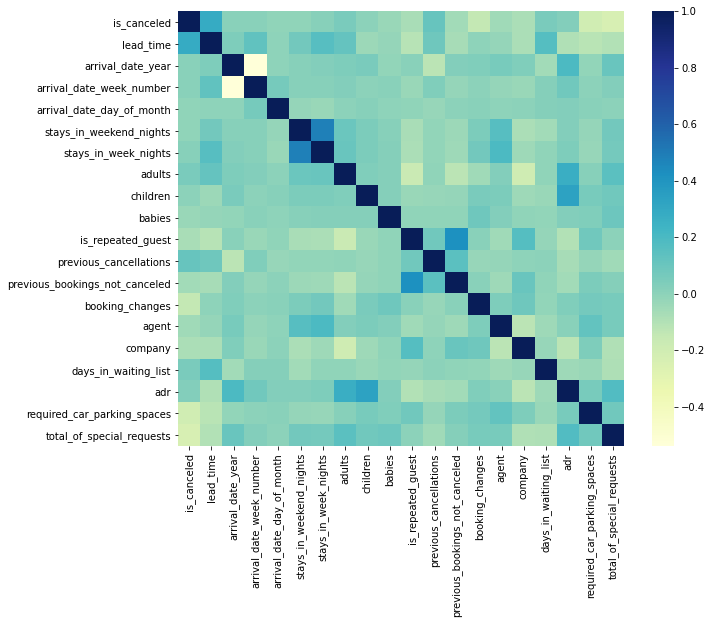

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),cmap="YlGnBu")

No column correlates linearly with is_booking, this means that linear regression and logistic regression won't work well on our data.

## Visualization

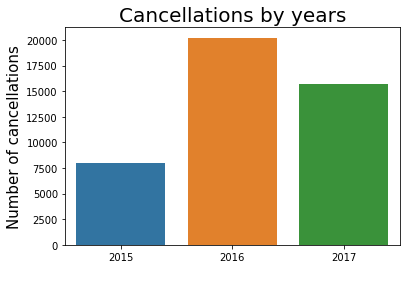

In [23]:
#cancellations through years
canceled_df = df[df['is_canceled']==1]
sns.countplot(canceled_df['arrival_date_year'])
plt.ylabel('Number of cancellations', fontsize=15)
plt.xlabel(' ')
plt.title('Cancellations by years', fontsize=20)
plt.show()

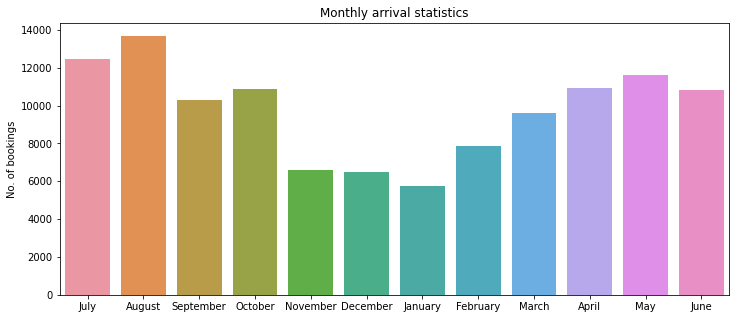

In [24]:
# Visualization of arrival on monthly basis for both types of hotels together
plt.figure(figsize=(12,5))
sns.countplot(df['arrival_date_month'])
plt.title('Monthly arrival statistics')
plt.xlabel('')
plt.ylabel('No. of bookings')
plt.xticks(rotation='horizontal')
plt.show()

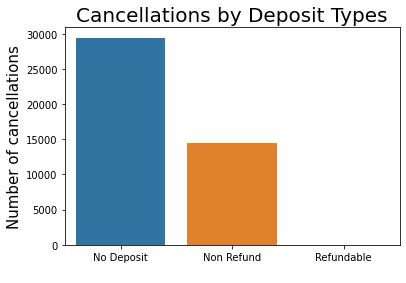

In [25]:
#cancellations by deposit_type
sns.countplot(canceled_df['deposit_type'])
plt.ylabel('Number of cancellations', fontsize=15)
plt.xlabel(' ')
plt.title('Cancellations by Deposit Types', fontsize=20)
plt.show()

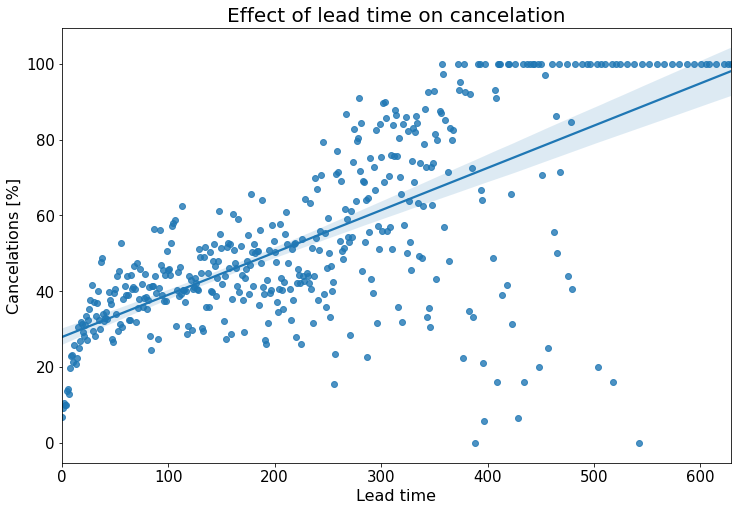

In [29]:
# group data for lead_time:
lead_time_df = df.groupby("lead_time")["is_canceled"].describe()
# use only lead_times wih more than 10 bookings for graph:
lead_time_df_10 = lead_time_df.loc[lead_time_df["count"] >= 10]


plt.figure(figsize=(12, 8))
sns.regplot(x=lead_time_df_10.index, y=lead_time_df_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=20)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
plt.show()

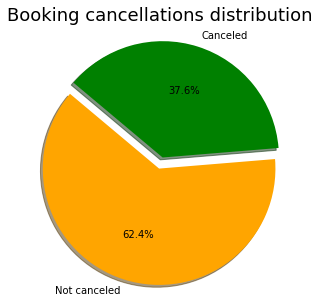

In [26]:
labels = 'Not canceled','Canceled'
sizes = df.is_canceled.value_counts().tolist()
colors = ['orange','green']
explode = (0.1, 0)  # explode 1st slice
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)
plt.rcParams.update({'font.size': 15})
plt.axis('equal')
plt.title('Booking cancellations distribution')
plt.show()

In [27]:
# total bookings per market segment (incl. canceled)
segments=df["market_segment"].value_counts()

# pie plot
fig = px.pie(segments,
             values=segments.values,
             names=segments.index,
             title="Bookings per market segment",
             template="seaborn")
fig.update_traces(rotation=-90, textinfo="percent+label")
fig.show()

## Preprocessing

In [0]:
categorical_cols = df.select_dtypes('object').columns.tolist()
df_dummied = pd.get_dummies(data=df, columns=categorical_cols)
X = df_dummied.drop('is_canceled', axis=1)
y = df['is_canceled']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=0)

In [0]:
sc = StandardScaler()

sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


In [0]:
base_models = [("DecisionTree", DecisionTreeClassifier(random_state=42)),
               ("RandomForest", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LogisticRegression", LogisticRegression(random_state=42,n_jobs=-1)),
               ("XGBoost", XGBClassifier(random_state=42, n_jobs=-1))]

# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

In [34]:
#Fitting, making predictions and scoring for every model:
for name, model in base_models:
    model_steps = model.fit(X,y)
    
    # get cross validation score for each model:
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    # output:
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuracy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DecisionTree cross validation accuracy score: 0.8603 +/- 0.0009 (std) min: 0.859, max: 0.8612
RandomForest cross validation accuracy score: 0.8941 +/- 0.002 (std) min: 0.8929, max: 0.8975


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



LogisticRegression cross validation accuracy score: 0.7716 +/- 0.0024 (std) min: 0.7691, max: 0.7742
XGBoost cross validation accuracy score: 0.8468 +/- 0.0019 (std) min: 0.8452, max: 0.85


RandomForestClassifier has the best performance so we will choose this model and let's see if we can improve the result

In [0]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

Accuracy score:

0.893072796537694

Confusion Matrix:

[[22321  1741]
 [ 2385 12140]]

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     24062
           1       0.87      0.84      0.85     14525

    accuracy                           0.89     38587
   macro avg       0.89      0.88      0.89     38587
weighted avg       0.89      0.89      0.89     38587



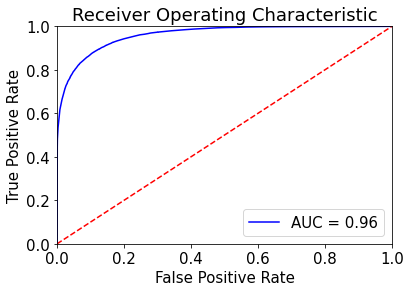

In [36]:
report = Report(X_test, y_test)
rfc = RandomForestClassifier(n_estimators=150,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=42)

model = rfc.fit(X_train, y_train)
report.metrics(model)
report.plot_roc_curve(model, save=True)

In [37]:
imp_cols= pd.DataFrame({'Feature': X.columns,'Importance':rfc.feature_importances_}).sort_values(by=['Importance'], ascending=[False])
imp_cols[:10]

,Feature,Importance
247,deposit_type_Non Refund,0.119285
0,lead_time,0.110275
246,deposit_type_No Deposit,0.083306
172,country_PRT,0.066722
16,adr,0.057693
18,total_of_special_requests,0.049386
13,agent,0.048420
3,arrival_date_day_of_month,0.043422
2,arrival_date_week_number,0.040107
220,market_segment_Online TA,0.033345


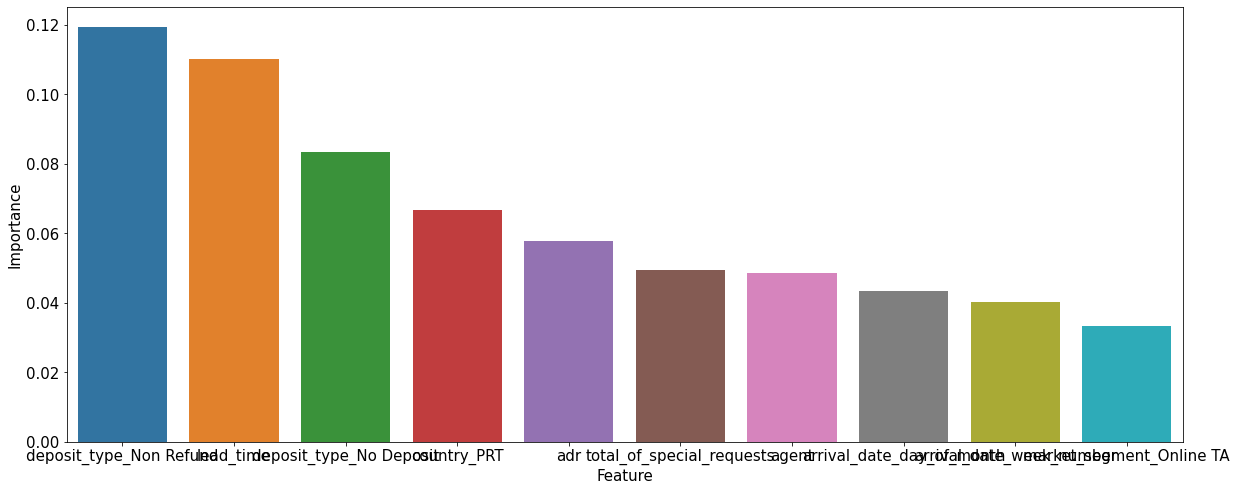

In [38]:
plt.figure(figsize=(20,8))
sns.barplot(x=imp_cols['Feature'][:10],y=imp_cols['Importance'][:10])
plt.show()

Deposit type, Lead time and ADR are the most important features in this model